# Diversified Beta Portfolio

## Key Assumptions:

* Risk is defined as the dispersion of future prices and returns. Mathematically it is defined as volatility or standard deviations.
* Investors get paid to take risk. Investors need to determine the appropriate level of risk for themselves.
* We cannot tell which asset class will be more efficient(more return per risk taken) and furthermore we do not expect any asset to be more efficient over the others in the long run. Therefore we should diversify our risk among asset classes equally.
* A diversified portfolio does not take enough risk. Therefore we use leverage to increase the risk and return of the strategy. The use of leverage is another risk to be considered.

I use the Equal Risk Contrbituition(ERC) strategy(also known as Risk Parity) to create my allocation from the assumptions above. You can read more about it below.

http://thierry-roncalli.com/download/erc.pdf

If you expect stocks to continue to outperform(return per risk basis), then an ERC strategy is not good for you. 

Note: If you just want the results, then skip ahead to the Recap.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import minimize

import sys
sys.path.insert(0, "\\\\ahccfpr12\\groups$\\Investments\\Git\\Util\\")
import Data

#needs blpapi to be installed
import pdblp

sys.path.insert(0, "\\\\ahccfpr12\\groups$\\Investments\\Git\\ffn\\")
import ffn

sys.path.insert(0, "\\\\ahccfpr12\\groups$\\Investments\\Git\\bt\\")
import bt


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
con = pdblp.BCon(port=8194)
con.start()

# Getting Data


In [4]:
tickers = {
    'LUATTRUU Index':'US Treasury',
    'LBUTTRUU Index':'US TIPS',
    'SPXT Index':'US Equities',
    'MXEA Index':'Developed ex. US Equities',
    'NDUEEGF Index':'Emerging Market Equities',
    'BCOMTR Index':'Commodities'
}

In [5]:
historical_tickers = ['LUATTRUU Index','LBUTTRUU Index','SPXT Index','NDUEEGF Index','BCOMTR Index']
flds = ['PX_LAST']
startDate = 19701231
pdf = con.bdh(historical_tickers, flds, startDate, '')
# remove multiindex
pdf.columns = pdf.columns.droplevel(1)

#pdf = pdf.resample('M').last()
pdf = pdf.dropna()
pdf.head()

ticker,LUATTRUU Index,LBUTTRUU Index,SPXT Index,NDUEEGF Index,BCOMTR Index
date,,,,,
1998-12-31,983.50,106.1116,1670.01,86.834,112.796
1999-01-04,982.38,105.6175,1668.52,88.327,113.411
1999-01-05,979.96,105.5680,1691.25,89.194,113.106
1999-01-06,982.35,106.3848,1729.08,91.248,115.245
1999-01-07,979.53,106.4571,1725.64,92.182,115.487


In [6]:
historical_tickers = ['G0O1 Index']
flds = ['PX_LAST']
startDate = 19981231
rfpdf = con.bdh(historical_tickers, flds, startDate, '')
# remove multiindex
rfpdf.columns = rfpdf.columns.droplevel(1)
rfpdf = rfpdf.dropna()
rfpdf.head()

ticker,G0O1 Index
date,
1998-12-31,487.883
1999-01-04,488.098
1999-01-05,488.170
1999-01-06,488.241
1999-01-07,488.347


In [8]:
rdf = pdf.pct_change()
rdf.head()

ticker,LUATTRUU Index,LBUTTRUU Index,SPXT Index,NDUEEGF Index,BCOMTR Index
date,,,,,
1998-12-31,NaN,NaN,NaN,NaN,NaN
1999-01-04,-0.001139,-0.004656,-0.000892,0.017194,0.005452
1999-01-05,-0.002463,-0.000469,0.013623,0.009816,-0.002689
1999-01-06,0.002439,0.007737,0.022368,0.023028,0.018911
1999-01-07,-0.002871,0.000680,-0.001989,0.010236,0.002100


In [60]:
print('Correlations')
rdf.corr()

Correlations


ticker,LUATTRUU Index,LBUTTRUU Index,SPXT Index,NDUEEGF Index,BCOMTR Index
ticker,,,,,
LUATTRUU Index,1.000000,0.758389,-0.331027,-0.224642,-0.162203
LBUTTRUU Index,0.758389,1.000000,-0.203420,-0.036506,0.020513
SPXT Index,-0.331027,-0.203420,1.000000,0.449635,0.232100
NDUEEGF Index,-0.224642,-0.036506,0.449635,1.000000,0.362305
BCOMTR Index,-0.162203,0.020513,0.232100,0.362305,1.000000


[]

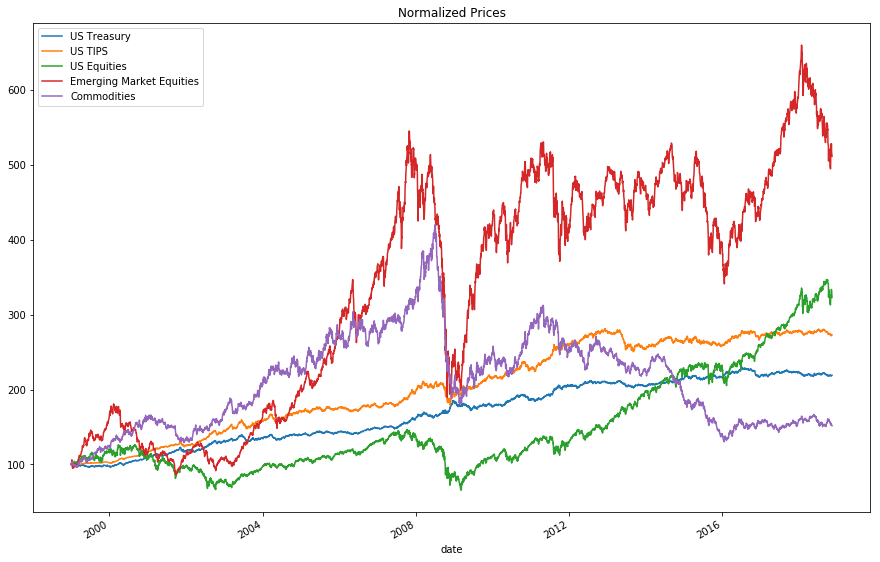

In [14]:
pdf2 = np.cumprod(1+rdf)*100
pdf2.iloc[0,:] = 100

fig, ax = plt.subplots(nrows=1,ncols=1)

for c in pdf2.columns:
    pdf2.loc[:,c].plot(ax=ax,label=tickers[c])

ax.legend()
ax.set_title('Normalized Prices')
ax.plot()

# Portfolio Analysis

### Equal Risk Contribution

In [15]:
covar = rdf.cov()*12
covar

ticker,LUATTRUU Index,LBUTTRUU Index,SPXT Index,NDUEEGF Index,BCOMTR Index
ticker,,,,,
LUATTRUU Index,0.000098,0.000090,-0.000137,-0.000095,-0.000057
LBUTTRUU Index,0.000090,0.000144,-0.000102,-0.000019,0.000009
SPXT Index,-0.000137,-0.000102,0.001745,0.000800,0.000342
NDUEEGF Index,-0.000095,-0.000019,0.000800,0.001815,0.000545
BCOMTR Index,-0.000057,0.000009,0.000342,0.000545,0.001247


#### Long Run Equal Risk Contributions

In [16]:
erc_weights_results = bt.ffn.core.calc_erc_weights(
    rdf,
    initial_weights=None,
    risk_weights=None,
    covar_method='standard',
    risk_parity_method='slsqp',
    maximum_iterations=100,
    tolerance=1E-8
)
erc_weights_results*100

ticker
LUATTRUU Index    44.837525
LBUTTRUU Index    26.991973
SPXT Index        10.027857
NDUEEGF Index      7.954724
BCOMTR Index      10.187921
Name: erc, dtype: float64

In [17]:
for c in erc_weights_results.index:
    print("%s:\t%0.2f" % (tickers[c], erc_weights_results[c]*100))

US Treasury:	44.84
US TIPS:	26.99
US Equities:	10.03
Emerging Market Equities:	7.95
Commodities:	10.19


#### Daily Recalculated Equal Risk Contributions

Below is a strategy where each day we find the weights for an ERC strategy.

In [18]:
runAfterDaysAlgo = bt.algos.RunAfterDays(
    253
)
runDailyAlgo = bt.algos.RunDaily(run_on_end_of_period=True)

weighERCAlgo = bt.algos.WeighERC(
    lookback=pd.DateOffset(months=12),
    covar_method='standard',
    risk_parity_method='slsqp',
    maximum_iterations=1000,
    tolerance=1e-7,
    lag=pd.DateOffset(days=1)
)

strat = bt.Strategy(
    'ERC',
    [
        runAfterDaysAlgo,
        runDailyAlgo,
        bt.algos.SelectAll(),
        weighERCAlgo,
        bt.algos.Rebalance()
    ]
)
    
test = bt.Backtest(
    strat,
    pdf,
    integer_positions = False,
    progress_bar=False
)
res_erc = bt.run(test)
res_erc.set_riskfree_rate(rfpdf['G0O1 Index'])

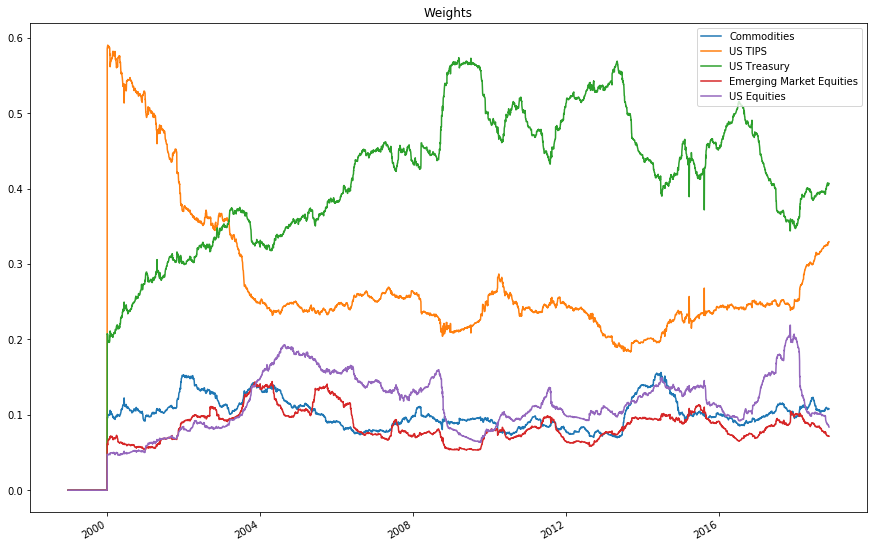

In [19]:
temp_wdf = res_erc.get_security_weights().copy()
fig, ax = plt.subplots(nrows=1,ncols=1)

for c in temp_wdf.columns:
    temp_wdf.loc[:,c].plot(ax=ax,label=tickers[c])

ax.legend()
ax.set_title('Weights')
ax.plot()
plt.show()

# Average Weights Over Time

Ideally, we would rebalance daily and use futures to match the exposures above. For a personal account it is unrealistic to rebalance daily because that would require a lot of effort and could incur taxes and transactions costs.

More realistically we will use long term weights, rebalance annually, and use levered ETFs. I would expect each of these changes to negatively impact the portfolio through either costs or capital efficiency(Sharpe Ratios).

First lets look into what using simplified, long term weights does to the portfolio.

In [20]:
#average weights across time
avg_weights = res_erc.get_security_weights().mean()

for c in avg_weights.index:
    print("%s:\t%0.2f%%" % (tickers[c], avg_weights[c]*100))

Commodities:	9.67%
US TIPS:	26.35%
US Treasury:	39.71%
Emerging Market Equities:	8.13%
US Equities:	11.01%


For simplicity, we will also look into the results of rounded weights with an equity tilt.

In [21]:
avg_weights_1 = pd.Series(
    {
        'LUATTRUU Index' : 0.3,
        'LBUTTRUU Index' : 0.3,
        'SPXT Index' : 0.15,
        'NDUEEGF Index' : 0.15,
        'BCOMTR Index' : 0.1
    }
)

for c in avg_weights_1.index:
    print("%s:\t%0.2f%%" % (tickers[c], avg_weights_1[c]*100))

Commodities:	10.00%
US TIPS:	30.00%
US Treasury:	30.00%
Emerging Market Equities:	15.00%
US Equities:	15.00%


Note:

I actually tried a few slightly different allocations. They were all really close to each other and it would be hard for me to say any allocation close to avg_weights_1 will outperform a priori. I went with 30/30/15/15/10 because it is more equity heavy but still a diversified portfolio.

Below we will simulate the average weight ERC allocation did historically.

In [22]:
runAfterDaysAlgo = bt.algos.RunAfterDays(
    253
)
runDailyAlgo = bt.algos.RunDaily(run_on_end_of_period=True)

selectTheseAlgo = bt.algos.SelectThese(
    [
        'LUATTRUU Index',
        'LBUTTRUU Index',
        'SPXT Index',
        'NDUEEGF Index',
        'BCOMTR Index'
    ]
)

weighSpecifiedAlgo = bt.algos.WeighSpecified(
    **avg_weights_1
)

strat = bt.Strategy(
    'ERC Avg Weights 1',
    [
        runAfterDaysAlgo,
        runDailyAlgo,
        selectTheseAlgo,
        weighSpecifiedAlgo,
        bt.algos.Rebalance()
    ]
)
    
test = bt.Backtest(
    strat,
    pdf,
    integer_positions = False,
    progress_bar=False
)
res_erc_avg_weights_1 = bt.run(test)
res_erc_avg_weights_1.set_riskfree_rate(rfpdf['G0O1 Index'])

[]

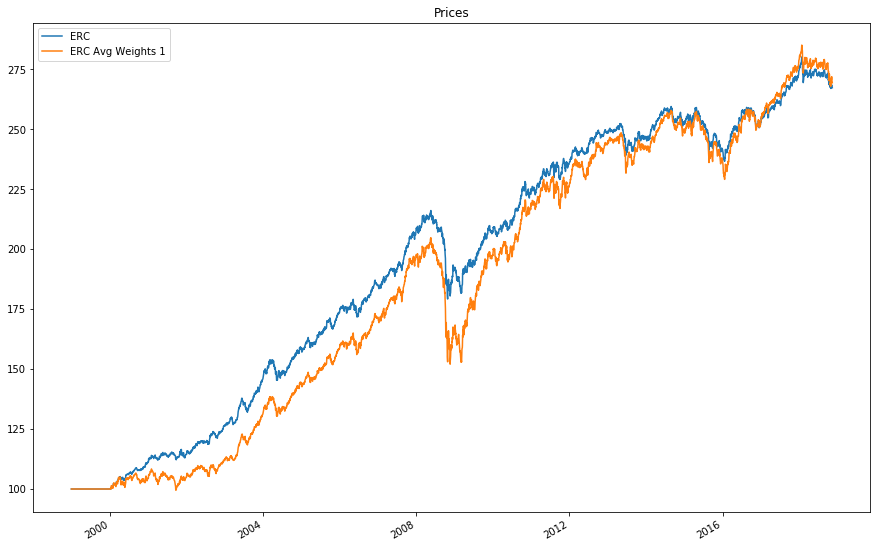

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=1)

res_erc.prices.plot(ax=ax)
res_erc_avg_weights_1.prices.plot(ax=ax)

ax.legend()
ax.set_title('Prices')
ax.plot()

The prices of the daily recalculated ERC portfolio is very similar to the portfolio of average weights over time. The time varying weights allocation(ERC) outperforms in the beginning but gives some of that back in the end. This isn't too surprising since the average weights were derived using data from the time varying weights.

When using static weights over time we are making the assumption that the covariance matrix does not change over time and we have estimated the long run covariance matrix.

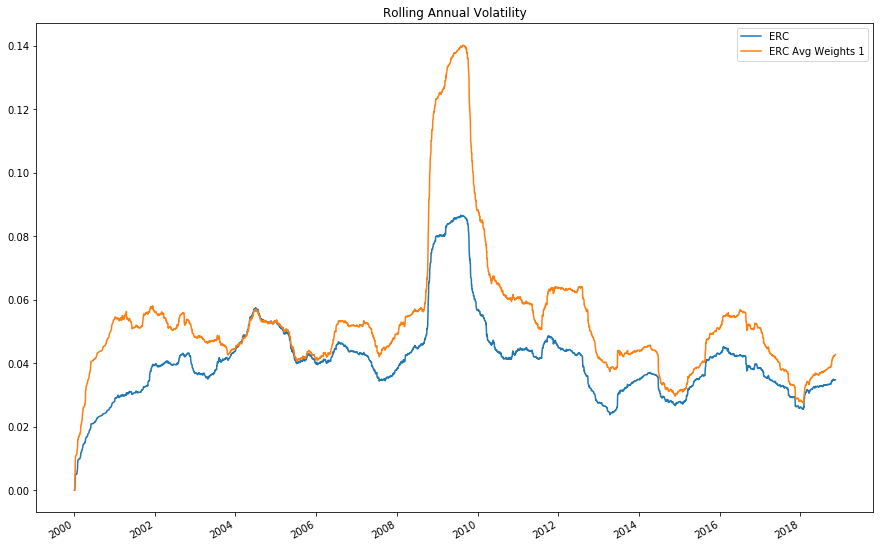

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=1)

(res_erc.prices.pct_change().rolling(window=252).std()*np.sqrt(252)).plot(ax=ax)
(res_erc_avg_weights_1.prices.pct_change().rolling(window=252).std()*np.sqrt(252)).plot(ax=ax)

ax.legend()
ax.set_title('Rolling Annual Volatility')
ax.plot()
plt.show()

Above is a chart of rolling annual volatility. Volatility is one common way of quantifying risk. Higher Volatility -> Higher Risk

Volatility is much higher for the strategies that use average weights through the GFC.

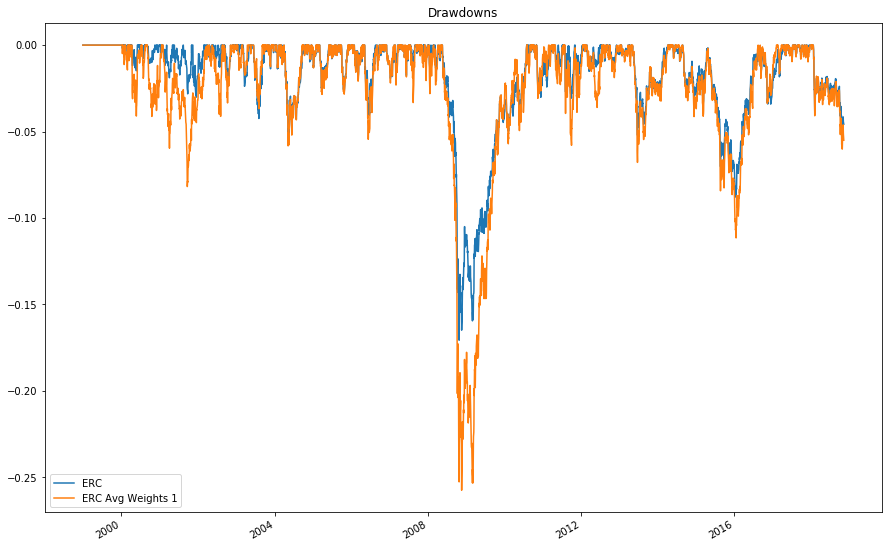

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=1)

(ffn.to_drawdown_series(res_erc.prices)).plot(ax=ax)
(ffn.to_drawdown_series(res_erc_avg_weights_1.prices)).plot(ax=ax)

ax.legend()
ax.set_title('Drawdowns')
ax.plot()
plt.show()

Above is a drawdown chart. It keeps track of the previous highest price for the strategy and then calculates what the loss from that point is. For example in 08, the average weights ERC strategy has a drawdown of 25% from it's previous highest price.

Returns over the long run seem to be the same but the drawdowns seem worse and volatility spikes even higher. The simplicity certainly comes at a cost but it is a simpler solution.

# Leverage

Now we need to find the amount of leverage we can use in the portfolio to get a higher risk and higher return portfolio. Personally, I would like a 12 to 14 volatility portfolio for me but that is personal to me and each person needs to determine the level of risk appropriate for themselves.

Because we are using leveraged ETFs(and not futures or other derivatives) we will not able to lever the portfolio up to any volatility we desire. The limitations to how much leverage we can use will be the amount of specific levered ETFs that we can buy without liquidity or other practical constraints.

If you have around 250k or more, then you will probably be able to use futures to recreate the portfolio and it is probably cheaper.

Below we will see the max amount of leverage that could be achieved if we deployed all of our capital every day into certain levered ETFs and a long duration TIPs ETF. Instead of using unlevered TIPS we can use long duration TIPS which should closely match a 2x levered benchmark. You can see proof of the relationship in the appendix. Using long duration TIPS will allow our portfolio to take more risk.

In [26]:
wdf = res_erc.get_security_weights().copy()
wdf_w_levered_etfs = wdf.copy()
#UPRO
wdf_w_levered_etfs['SPXT Index'] = wdf_w_levered_etfs['SPXT Index']/3
#UST
wdf_w_levered_etfs['LUATTRUU Index'] = wdf_w_levered_etfs['LUATTRUU Index']/2
#LTPZ
wdf_w_levered_etfs['LBUTTRUU Index'] = wdf_w_levered_etfs['LBUTTRUU Index']/2
#CMDY
wdf_w_levered_etfs['BCOMTR Index'] = wdf_w_levered_etfs['BCOMTR Index']/1
#EDC
wdf_w_levered_etfs['NDUEEGF Index'] = wdf_w_levered_etfs['NDUEEGF Index']/3

wdf_w_levered_etfs['Total'] = wdf_w_levered_etfs.sum(axis=1)
wdf_w_levered_etfs['Max Leverage'] = 1/wdf_w_levered_etfs['Total']

wdf_w_levered_etfs.tail()

,BCOMTR Index,LBUTTRUU Index,LUATTRUU Index,NDUEEGF Index,SPXT Index,Total,Max Leverage
2018-11-06,0.108436,0.164051,0.202457,0.024071,0.028779,0.527793,1.894681
2018-11-07,0.108384,0.164070,0.202445,0.024072,0.028790,0.527761,1.894796
2018-11-08,0.108495,0.164317,0.202593,0.024090,0.028472,0.527967,1.894059
2018-11-09,0.108319,0.164292,0.202670,0.024096,0.028490,0.527867,1.894416
2018-11-13,0.107928,0.164811,0.203505,0.023882,0.027931,0.528057,1.893734


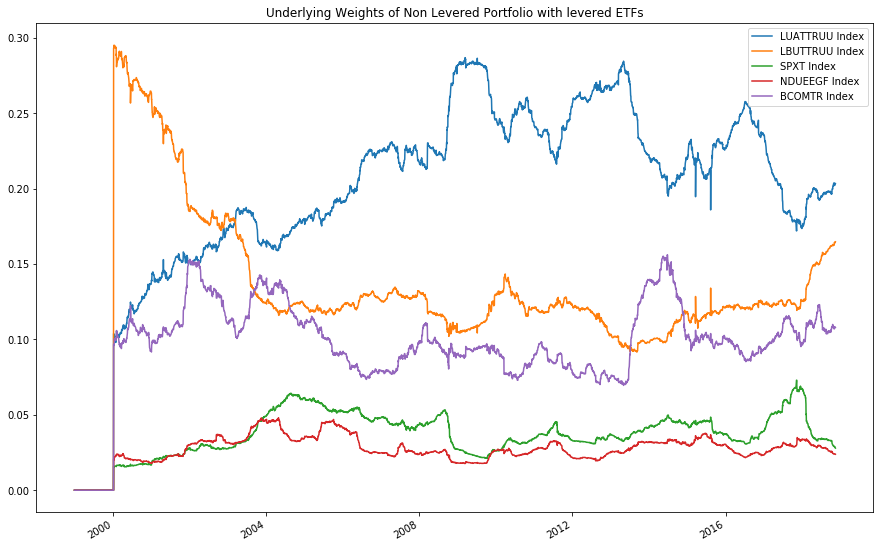

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=1)
wdf_w_levered_etfs.loc[
    :,
    [
        'LUATTRUU Index',
        'LBUTTRUU Index',
        'SPXT Index',
        'NDUEEGF Index',
        'BCOMTR Index'
    ]
].plot(ax=ax)
ax.set_title('Underlying Weights of Non Levered Portfolio with levered ETFs')
ax.plot()
plt.show()

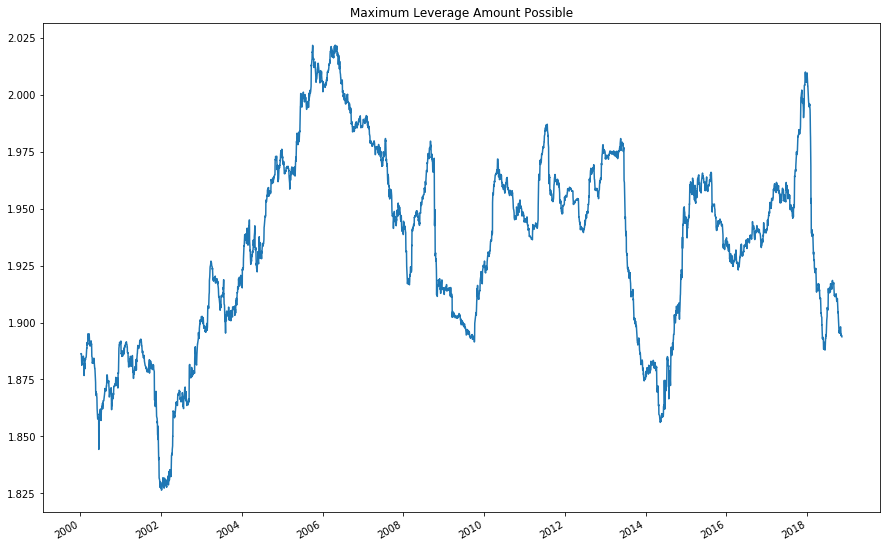

In [28]:
fig, ax = plt.subplots(nrows=1,ncols=1)
wdf_w_levered_etfs['Max Leverage'].plot(ax = ax)
ax.set_title('Maximum Leverage Amount Possible')
ax.plot()
plt.show()

The graph above shows the maximum amount of leverage possible using the instruments we have for the daily ERC portfolio.

Now that we have the amount of leverage possible, we can see the levered weights of a portfolio that is rebalanced daily.

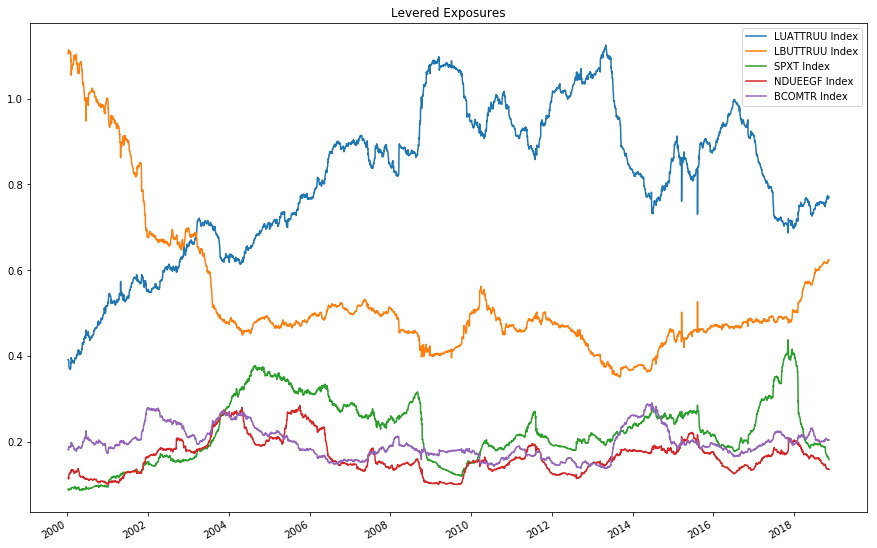

In [29]:
wdf_levered = wdf.loc[:,[
        'LUATTRUU Index',
        'LBUTTRUU Index',
        'SPXT Index',
        'NDUEEGF Index',
        'BCOMTR Index'
    ]
].copy()
for c in wdf_levered.columns:
    wdf_levered[c] = wdf_levered[c]*wdf_w_levered_etfs['Max Leverage']
    
wdf_levered.plot()
plt.title('Levered Exposures')
plt.show()

The daily rebalanced, ERC portfolio can't get enough leverage consistently without futures. In a non-qualified(brokerage) account the daily rebalancing would be cumbersome and throw off tax issues. We need a portfolio that we can rebalance annually that gets enough risk. Let's look back at the average weights and lever the portfolio up as much as we can.

In [30]:
avg_weights_1

BCOMTR Index      0.10
LBUTTRUU Index    0.30
LUATTRUU Index    0.30
NDUEEGF Index     0.15
SPXT Index        0.15
dtype: float64

In [34]:
avg_weights_1_levered = avg_weights_1.copy()

#UPRO
avg_weights_1_levered['SPXT Index'] = avg_weights_1_levered['SPXT Index']/3
#UST
avg_weights_1_levered['LUATTRUU Index'] = avg_weights_1_levered['LUATTRUU Index']/2
#LTPZ
avg_weights_1_levered['LBUTTRUU Index'] = avg_weights_1_levered['LBUTTRUU Index']/2
#CMDY
avg_weights_1_levered['BCOMTR Index'] = avg_weights_1_levered['BCOMTR Index']/1
#EDC
avg_weights_1_levered['NDUEEGF Index'] = avg_weights_1_levered['NDUEEGF Index']/3

for c in avg_weights_1_levered.index:
    print("%s:\t%0.2f%%" % (tickers[c], avg_weights_1_levered[c]*100))
print("Total Leverage possible:\t%0.1fx" % (1/avg_weights_1_levered.sum()))

Commodities:	10.00%
US TIPS:	15.00%
US Treasury:	15.00%
Emerging Market Equities:	5.00%
US Equities:	5.00%
Total Leverage possible:	2.0x


In [35]:
runAfterDaysAlgo = bt.algos.RunAfterDays(
    253
)
runDailyAlgo = bt.algos.RunDaily(run_on_end_of_period=True)

selectTheseAlgo = bt.algos.SelectThese(
    [
        'LUATTRUU Index',
        'LBUTTRUU Index',
        'SPXT Index',
        'NDUEEGF Index',
        'BCOMTR Index'
    ]
)

weighSpecifiedAlgo = bt.algos.WeighSpecified(
    **(avg_weights_1*2)
)

strat = bt.Strategy(
    'ERC Levered Avg Weights 1',
    [
        runAfterDaysAlgo,
        runDailyAlgo,
        selectTheseAlgo,
        weighSpecifiedAlgo,
        bt.algos.Rebalance()
    ]
)
    
test = bt.Backtest(
    strat,
    pdf,
    integer_positions = False,
    progress_bar=False
)
res_erc_levered_avg_weights_1 = bt.run(test)
res_erc_levered_avg_weights_1.set_riskfree_rate(rfpdf['G0O1 Index'])

In [36]:
runAfterDaysAlgo = bt.algos.RunAfterDays(
    253
)
runDailyAlgo = bt.algos.RunDaily(run_on_end_of_period=True)

selectTheseAlgo = bt.algos.SelectThese(
    [
        'LUATTRUU Index',
        'LBUTTRUU Index',
        'SPXT Index',
        'NDUEEGF Index',
        'BCOMTR Index'
    ]
)

weighTargetAlgo = bt.algos.WeighTarget(
    wdf_levered
)

strat = bt.Strategy(
    'ERC Levered',
    [
        runAfterDaysAlgo,
        runDailyAlgo,
        selectTheseAlgo,
        weighTargetAlgo,
        bt.algos.Rebalance()
    ]
)
    
test = bt.Backtest(
    strat,
    pdf,
    integer_positions = False,
    progress_bar=False
)
res_erc_levered = bt.run(test)
res_erc_levered.set_riskfree_rate(rfpdf['G0O1 Index'])

In [37]:
sp500_prices = np.cumprod(1+rdf.loc[:,'SPXT Index'])*100
sp500_prices[0] = 100

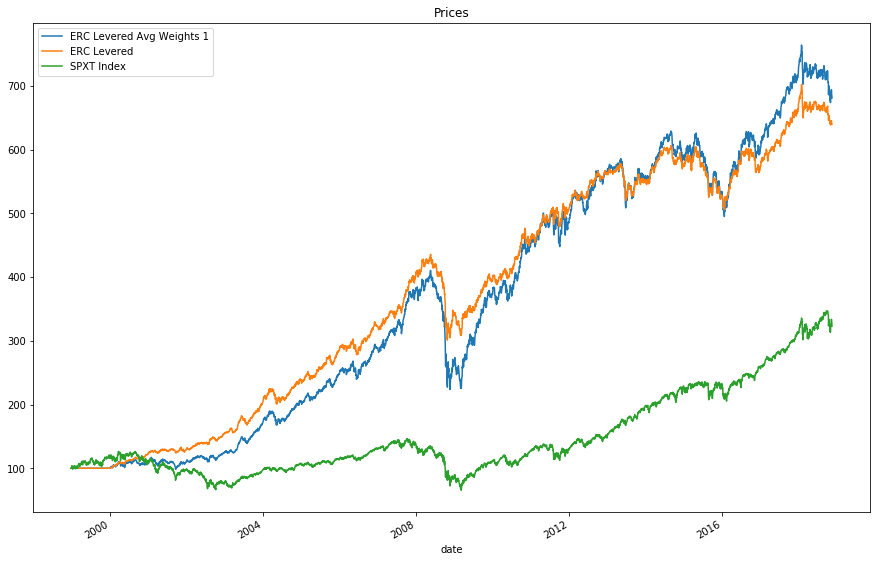

In [38]:
fig, ax = plt.subplots(nrows=1,ncols=1)

res_erc_levered_avg_weights_1.prices.plot(ax=ax)
res_erc_levered.prices.plot(ax=ax)
sp500_prices.plot(ax=ax)

ax.legend()
ax.set_title('Prices')
ax.plot()
plt.show()

* SPXT Index is the total return of the S&P 500
* ERC Levered is the equal risk contribution strategy that is fully levered and recalculated daily
* ERC Levered Avg Weights 1 is the rounded, average weights of ERC


As expected a levered, diversified portfolio outperforms the equites(or any one asset class). The only case that any one asset class outperforms a levered, diversified portfolio is where the asset class is more efficient over that time frame.

ERC Levered and ERC Levered Avg Weights 1 are similar.

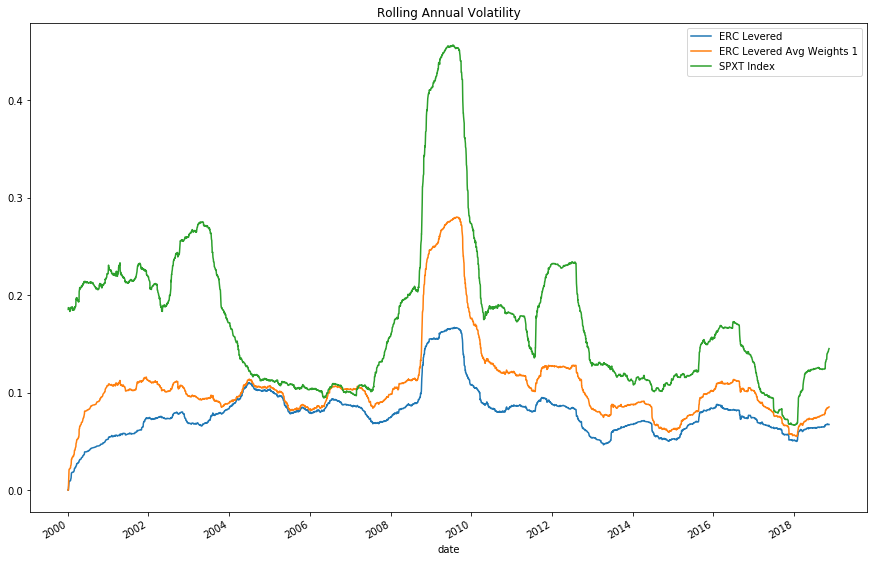

In [39]:
fig, ax = plt.subplots(nrows=1,ncols=1)

(res_erc_levered.prices.pct_change().rolling(window=252).std()*np.sqrt(252)).plot(ax=ax)
(res_erc_levered_avg_weights_1.prices.pct_change().rolling(window=252).std()*np.sqrt(252)).plot(ax=ax)
(sp500_prices.pct_change().rolling(window=252).std()*np.sqrt(252)).plot(ax=ax)

ax.legend()
ax.set_title('Rolling Annual Volatility')
ax.plot()
plt.show()

US Equities is more risky than both levered ERC strategies(daily recalculated ERC and average weights ERC).

Daily recalculated ERC is less risky than the average weights ERC which is what we would expect because it adapts to the environment.

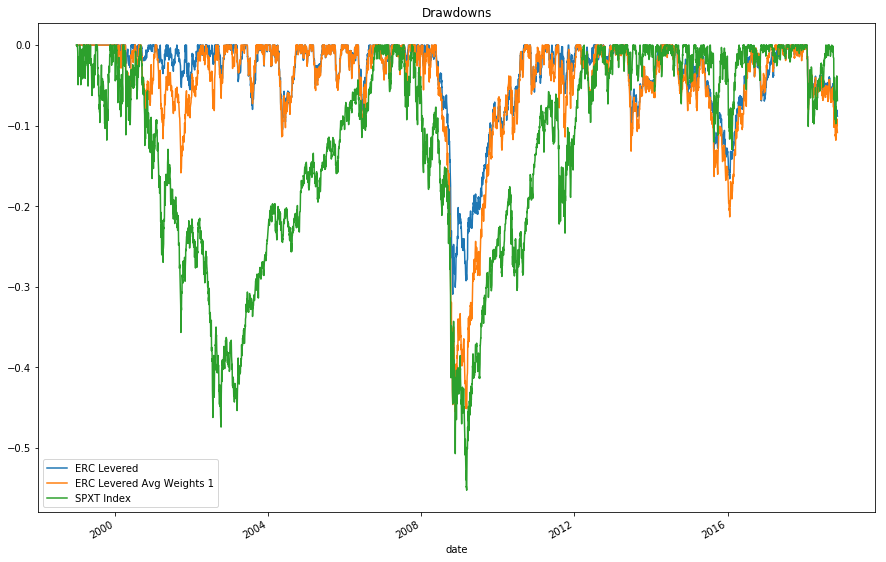

In [40]:
fig, ax = plt.subplots(nrows=1,ncols=1)

(ffn.to_drawdown_series(res_erc_levered.prices)).plot(ax=ax)
(ffn.to_drawdown_series(res_erc_levered_avg_weights_1.prices)).plot(ax=ax)
(ffn.to_drawdown_series(sp500_prices)).plot(ax=ax)

ax.legend()
ax.set_title('Drawdowns')
ax.plot()
plt.show()

The drawdowns for both ERC strategies are less risky than US Equities but they still have large drawdowns at times.

The important caveat here is that these are portfolios built of indices and excluding transaction costs. These results are not realistic of actual portfolios. Later on we will use actual ETFs to represent investable portfolios which will include fees and change rebalancing to annual to lessen transaction costs.

In [41]:
statsdf_levered = pd.merge(
    res_erc_levered.stats,
    res_erc_levered_avg_weights_1.stats,
    left_index=True,
    right_index=True
)

sp500_performance_stats = ffn.PerformanceStats(sp500_prices)
sp500_performance_stats.set_riskfree_rate(rfpdf['G0O1 Index'])
statsdf_levered[sp500_performance_stats.name] = sp500_performance_stats.stats

statsdf_levered.loc[
    [
        'cagr',
        'max_drawdown',
        'monthly_sharpe',
        'monthly_mean',
        'monthly_vol',
        'win_year_perc'
    ],
    :    
]

,ERC Levered,ERC Levered Avg Weights 1,SPXT Index
cagr,0.0979158,0.101359,0.0608001
max_drawdown,-0.3092,-0.455261,-0.552502
monthly_sharpe,0.845693,0.671874,0.352751
monthly_mean,0.0979894,0.105102,0.0694007
monthly_vol,0.0936275,0.128436,0.14342
win_year_perc,0.75,0.75,0.8


* cagr stands for compounded annual growth rate or the expected annual return of a portfolio(in % terms) invested in the strategy

As you saw in the price charts both ERC strategies outperform US Equities.

In [42]:
wdf_erc_levered_avg_weights_1 = res_erc_levered_avg_weights_1.get_security_weights().copy()
wdf_erc_levered_avg_weights_1 = wdf_erc_levered_avg_weights_1.loc[pdf.index,:]

In [43]:
rolling_cov = pdf.loc[:,wdf_erc_levered_avg_weights_1.columns].pct_change().rolling(window=252).cov()*252

trc = pd.DataFrame(
    np.nan,
    index = wdf_erc_levered_avg_weights_1.index,
    columns = wdf_erc_levered_avg_weights_1.columns
)
vol = pd.Series(
    np.nan,
    index = wdf_erc_levered_avg_weights_1.index,
)

for dt in wdf_erc_levered_avg_weights_1.index:
    vol[dt] = np.sqrt(wdf_erc_levered_avg_weights_1.loc[dt,:].values@rolling_cov.loc[dt,:].values@wdf_erc_levered_avg_weights_1.loc[dt,:].values)
    trc.loc[dt,:] = wdf_erc_levered_avg_weights_1.loc[dt,:].values*rolling_cov.loc[dt,:].values@wdf_erc_levered_avg_weights_1.loc[dt,:].values/vol[dt]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


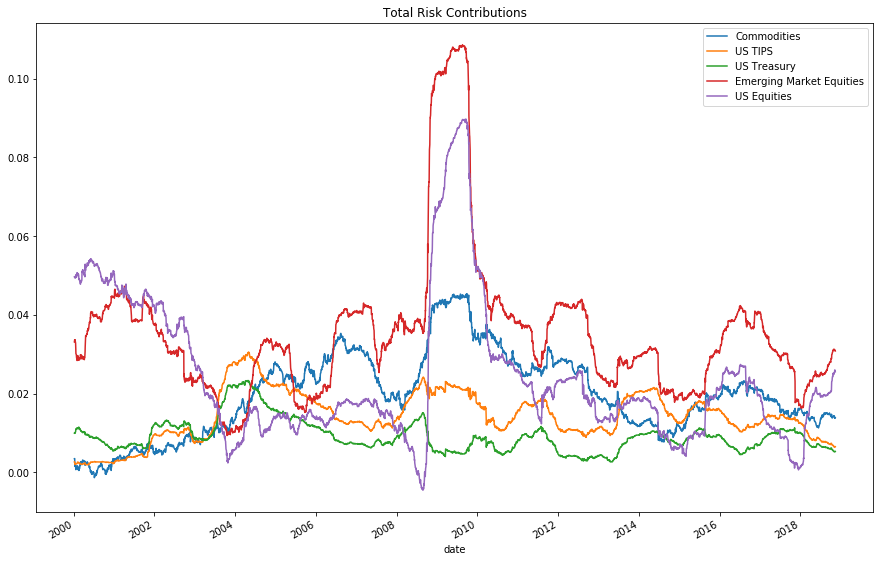

In [44]:
fig, ax = plt.subplots(nrows=1,ncols=1)

for c in trc.columns:
    trc.loc[:,c].plot(ax=ax,label=tickers[c])

ax.legend()
ax.set_title('Total Risk Contributions')
ax.plot()
plt.show()

Looking at total risk contributions we would ideally see that over the long run each index contributes to risk equally and we aren't over emphasizing any particular asset class(hence the name equal risk contribution). We do not quite see this because this is a long run approximation of an ERC strategy.

# Simulate Strategy on Live Data

Now to incorporate fees and to simulate an investable portfolio.

Each of the ETFs include dividends reinvested and adjusts for splits and reverse splits.

In [45]:
historical_tickers = ['UPRO US Equity','UST US Equity','TIP US Equity','LTPZ US Equity','DJP US Equity','EDC US Equity']
flds = ['PX_LAST']
startDate = 20071231
pdf_etf = con.bdh(historical_tickers, flds, startDate, '',elms=[("UseDPDF","N"), ("CshAdjNormal","Y"),("CshAdjAbnormal","Y"),("CapChg","Y")])
# remove multiindex
pdf_etf.columns = pdf_etf.columns.droplevel(1)

pdf_etf = pdf_etf.dropna()
pdf_etf.head()

ticker,UPRO US Equity,UST US Equity,TIP US Equity,LTPZ US Equity,DJP US Equity,EDC US Equity
date,,,,,,
2010-01-22,3.8709,32.7907,87.8902,42.9574,40.670,183.3484
2010-01-25,3.9186,32.5747,87.6646,42.7795,40.800,185.4558
2010-01-26,3.8693,32.7217,87.9320,42.9611,40.290,174.5066
2010-01-27,3.9271,32.5655,87.6980,43.1309,39.471,173.7460
2010-01-28,3.7896,32.5609,87.8150,42.9820,39.340,170.1966


UPRO - US Equities ETF 3x Levered

UST - US Treasuries ETF 2x Levered

TIP - US TIPS ETF

LTPZ - US Long Duration TIPS ETF

DJP - iPath Bloomberg Commodity Index Total Return ETN

EDC - Emerging Market Equities ETF 3x Levered

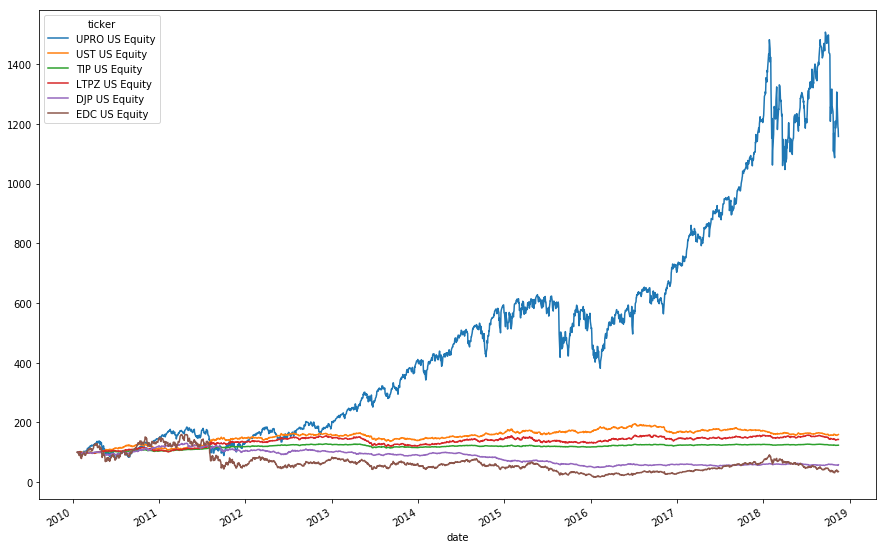

In [46]:
rdf_etf = pdf_etf.pct_change()
pdf_etf2 = np.cumprod(1+rdf_etf)*100
pdf_etf2.iloc[0,:] = 100
pdf_etf2.plot()

In [47]:
#UPRO - US Equities
#UST - US Treasury
#LTPZ - Long Duration TIPS
#DJP - Commodities
#EDC - Emerging Market Equities
etf_2_index = {
    'UPRO US Equity' : 'SPXT Index',
    'UST US Equity' : 'LUATTRUU Index',
    #'TIP US Equity' : 'LBUTTRUU Index',
    'LTPZ US Equity' : 'LBUTTRUU Index',
    'DJP US Equity' : 'BCOMTR Index',
    'EDC US Equity' : 'NDUEEGF Index'
}
index_2_etf = {v: k for k, v in etf_2_index.items()}

In [48]:
avg_weights_1_levered

BCOMTR Index      0.10
LBUTTRUU Index    0.15
LUATTRUU Index    0.15
NDUEEGF Index     0.05
SPXT Index        0.05
dtype: float64

In [49]:
avg_weights_1_levered_with_etfs = {}
for index in avg_weights_1_levered.index:
    avg_weights_1_levered_with_etfs[index_2_etf[index]] = avg_weights_1_levered[index]*2

avg_weights_1_levered_with_etfs = pd.Series(avg_weights_1_levered_with_etfs)
print(avg_weights_1_levered_with_etfs)
print("%0.2f%% of Capital Used" % (avg_weights_1_levered_with_etfs.sum()*100))

DJP US Equity     0.2
EDC US Equity     0.1
LTPZ US Equity    0.3
UPRO US Equity    0.1
UST US Equity     0.3
dtype: float64
100.00% of Capital Used


In [50]:
runAfterDaysAlgo = bt.algos.RunAfterDays(
    253
)
runDailyAlgo = bt.algos.RunDaily(run_on_end_of_period=True)

selectTheseAlgo = bt.algos.SelectThese(
    [
        'UPRO US Equity',
        'UST US Equity',
        'LTPZ US Equity',
        'DJP US Equity',
        'EDC US Equity'
    ]
)

weighSpecifiedAlgoo = bt.algos.WeighSpecified(
    **(avg_weights_1_levered_with_etfs.to_dict())
)

strat = bt.Strategy(
    'ERC Levered Avg Weights 1 with ETFs',
    [
        runAfterDaysAlgo,
        runDailyAlgo,
        selectTheseAlgo,
        weighSpecifiedAlgoo,
        bt.algos.Rebalance()
    ]
)
    
test = bt.Backtest(
    strat,
    pdf_etf,
    integer_positions = False,
    progress_bar=False
)
res_erc_levered_avw1_w_etf = bt.run(test)
res_erc_levered_avw1_w_etf.set_riskfree_rate(rfpdf['G0O1 Index'])

In [51]:
start_date = res_erc_levered_avw1_w_etf.prices.index[254]

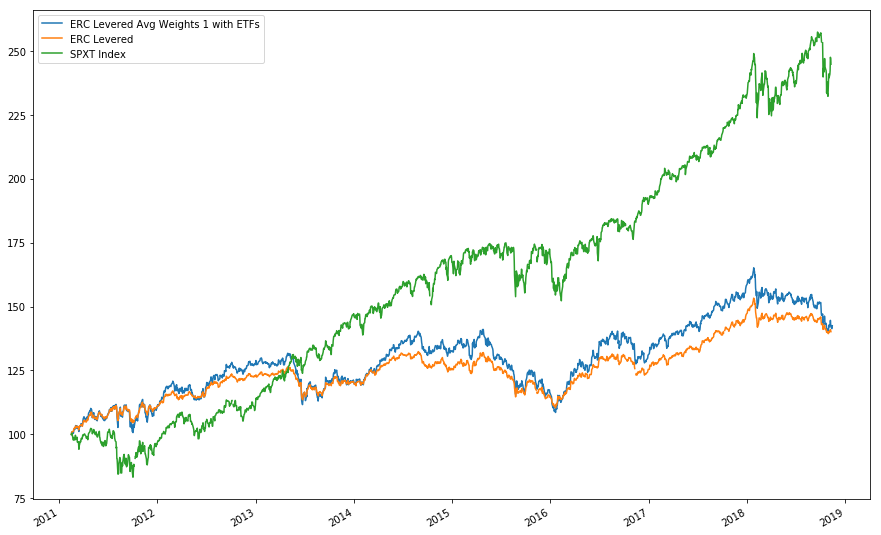

In [52]:
pdf_later_sd = res_erc_levered_avw1_w_etf.prices.loc[start_date:].copy()

pdf_later_sd[res_erc_levered_avw1_w_etf.prices.columns[0]] = (res_erc_levered_avw1_w_etf.prices.loc[start_date:]/res_erc_levered_avw1_w_etf.prices.loc[start_date].values[0]*100)
pdf_later_sd[res_erc_levered.prices.columns[0]] = (res_erc_levered.prices.loc[start_date:]/res_erc_levered.prices.loc[start_date].values[0]*100)
pdf_later_sd[sp500_prices.name] = (sp500_prices.loc[start_date:]/sp500_prices.loc[start_date]*100)

pdf_later_sd.plot()
plt.show()

* ERC Levered Avg Weights 1 with ETFs is the investable portfolio for the average weights in ETFs.

Since 2011 US Equities sharply outperforms.

Using live data restricts our start date to 2011. Unfortunately this time frame doesn't cover any economic recessions or drawdowns for equities. Hence equities look great. If you expect equities to continue to be the most efficient asset class like it has been since 2011 but unlike it's results since 1999(or even further back in history or in other geographies), then you should invest only in equities. I do not expect Equities to be the most efficient asset class therefore I want to diversify across several asset class.

In [53]:
group_stats_later_sd = ffn.GroupStats(pdf_later_sd)
statsdf_actual = pd.DataFrame(group_stats_later_sd['ERC Levered'].stats,columns=['ERC Levered'])

for name,res in group_stats_later_sd.items():
    if name == 'ERC Levered':
        continue
    statsdf_actual[name] = res.stats

statsdf_actual.loc[
    [
        'cagr',
        'max_drawdown',
        'monthly_sharpe',
        'monthly_mean',
        'monthly_vol',
        'win_year_perc'
    ],
    :    
]

\\ahccfpr12\groups$\Investments\Git\ffn\ffn\core.py:2149: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


,ERC Levered,ERC Levered Avg Weights 1 with ETFs,SPXT Index
cagr,0.0441999,0.0457704,0.119484
max_drawdown,-0.165865,-0.230018,-0.186407
monthly_sharpe,0.564744,0.435947,1.10473
monthly_mean,0.0433845,0.0483043,0.120648
monthly_vol,0.0768215,0.110803,0.10921
win_year_perc,0.571429,0.571429,1


It is good to see that the investable portfolio(ERC Levered Avg Weights 1 with ETFs) with ETFs doesn't take a large hit in performance but with that said I would not put too much emphasis on these results because we have only been in 1 unique macro environment.

# Rebalancing Annually

Now let's look at the portfolio if we rebalance annually which is ideal for taxes. It is much more practical for an individual investor to rebalance annually. Ignoring transaction costs I expect rebalancing less often to hurt the portfolio.

In [54]:
runAfterDaysAlgo = bt.algos.RunAfterDays(
    253
)
runYearlyAlgo = bt.algos.RunYearly(run_on_end_of_period=True)

selectTheseAlgo = bt.algos.SelectThese(
    [
        'UPRO US Equity',
        'UST US Equity',
        'LTPZ US Equity',
        'DJP US Equity',
        'EDC US Equity'
    ]
)

weighSpecifiedAlgo = bt.algos.WeighSpecified(
    **(avg_weights_1_levered_with_etfs.to_dict())
)

strat = bt.Strategy(
    'ERC Levered Avg Weights 1 with ETFs Rebalanced Annually',
    [
        runAfterDaysAlgo,
        runYearlyAlgo,
        selectTheseAlgo,
        weighSpecifiedAlgo,
        bt.algos.Rebalance()
    ]
)
    
test = bt.Backtest(
    strat,
    pdf_etf,
    integer_positions = False,
    progress_bar=False
)
res_erc_levered_avw1_w_etf_reb_ann = bt.run(test)
res_erc_levered_avw1_w_etf_reb_ann.set_riskfree_rate(rfpdf['G0O1 Index'])

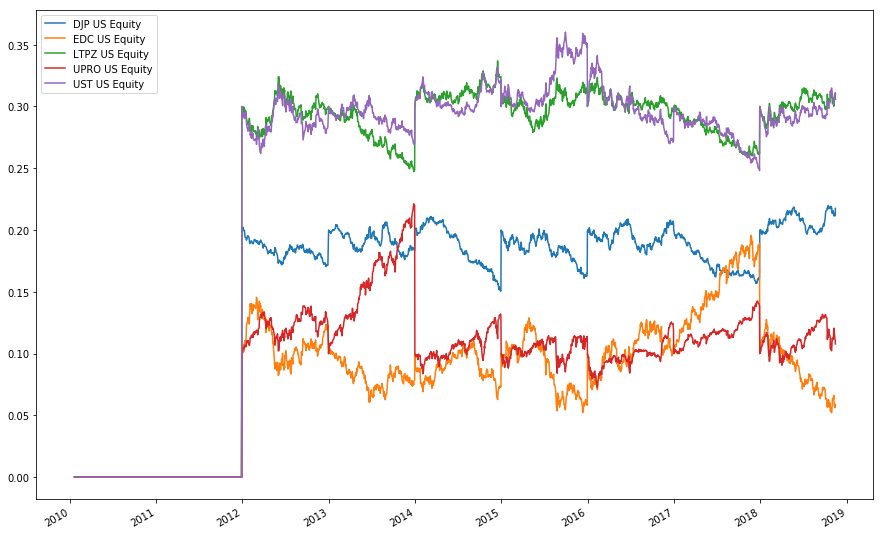

In [55]:
res_erc_levered_avw1_w_etf_reb_ann.get_security_weights().plot()
plt.show()

In [56]:
start_date = res_erc_levered_avw1_w_etf_reb_ann.prices.index[465]

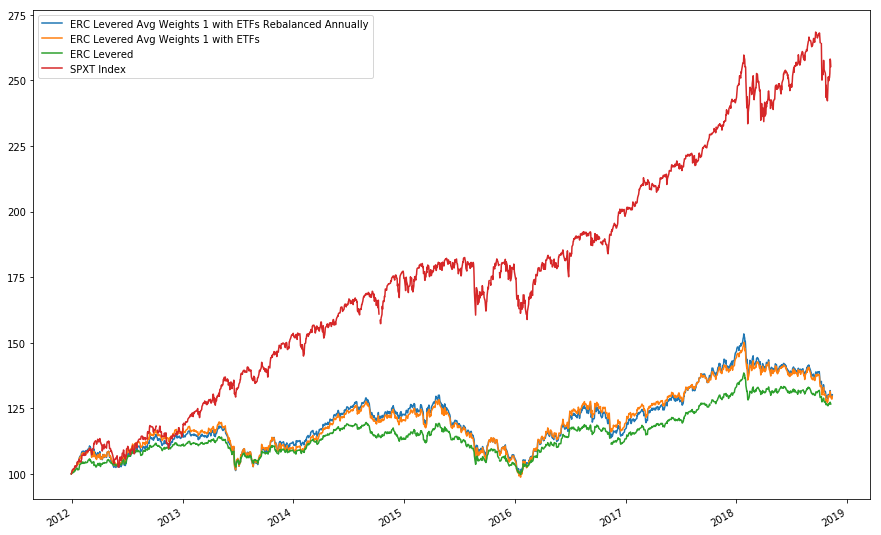

In [57]:
pdf_later_sd = res_erc_levered_avw1_w_etf_reb_ann.prices.loc[start_date:].copy()

pdf_later_sd[res_erc_levered_avw1_w_etf.prices.columns[0]] = (res_erc_levered_avw1_w_etf.prices.loc[start_date:]/res_erc_levered_avw1_w_etf.prices.loc[start_date].values[0]*100)
pdf_later_sd[res_erc_levered_avw1_w_etf_reb_ann.prices.columns[0]] = (res_erc_levered_avw1_w_etf_reb_ann.prices.loc[start_date:]/res_erc_levered_avw1_w_etf_reb_ann.prices.loc[start_date].values[0]*100)
pdf_later_sd[res_erc_levered.prices.columns[0]] = (res_erc_levered.prices.loc[start_date:]/res_erc_levered.prices.loc[start_date].values[0]*100)
pdf_later_sd[sp500_prices.name] = (sp500_prices.loc[start_date:]/sp500_prices.loc[start_date]*100)

pdf_later_sd.plot()
plt.show()

* ERC Levered Avg Weights 1 with ETFs Rebalanced Annually represents the investable ERC portfolio that is rebalanced annually.

Looking at the prices we see very similar performance between all ERC strategies.

In [58]:
group_stats_later_sd = ffn.GroupStats(pdf_later_sd)
statsdf_actual = pd.DataFrame(group_stats_later_sd['ERC Levered'].stats,columns=['ERC Levered'])

for name,res in group_stats_later_sd.items():
    if name == 'ERC Levered':
        continue
    statsdf_actual[name] = res.stats

statsdf_actual.loc[
    [
        'cagr',
        'max_drawdown',
        'monthly_sharpe',
        'monthly_mean',
        'monthly_vol',
        'win_year_perc'
    ],
    :    
]

\\ahccfpr12\groups$\Investments\Git\ffn\ffn\core.py:2149: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


,ERC Levered,ERC Levered Avg Weights 1 with ETFs Rebalanced Annually,ERC Levered Avg Weights 1 with ETFs,SPXT Index
cagr,0.0344925,0.0380113,0.0371931,0.142574
max_drawdown,-0.165865,-0.230465,-0.230018,-0.129554
monthly_sharpe,0.499836,0.411933,0.403757,1.38238
monthly_mean,0.0363603,0.0423832,0.0416041,0.138075
monthly_vol,0.0727445,0.102889,0.103043,0.099882
win_year_perc,0.571429,0.571429,0.571429,1


Rebalancing annually doesn't change annual returns and results in a 0.08 Sharpe decrease. Again, I wouldn't over emphasize these numbers too much because it is over a short time frame relatively speaking.

Lets look at drawdowns.

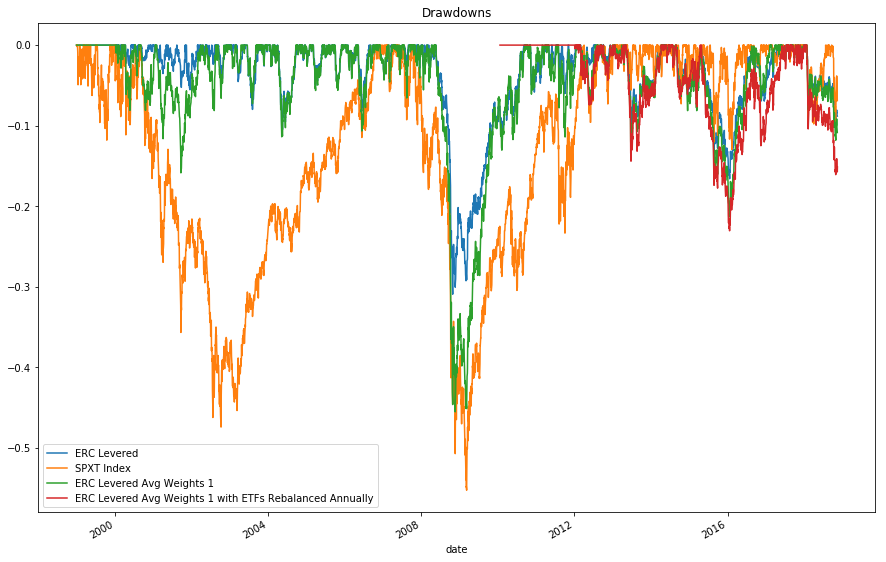

In [59]:
fig, ax = plt.subplots(nrows=1,ncols=1)

(ffn.to_drawdown_series(res_erc_levered.prices)).plot(ax=ax)
(ffn.to_drawdown_series(sp500_prices)).plot(ax=ax)
(ffn.to_drawdown_series(res_erc_levered_avg_weights_1.prices)).plot(ax=ax)
(ffn.to_drawdown_series(res_erc_levered_avw1_w_etf_reb_ann.prices)).plot(ax=ax)

ax.legend()
ax.set_title('Drawdowns')
ax.plot()
plt.show()

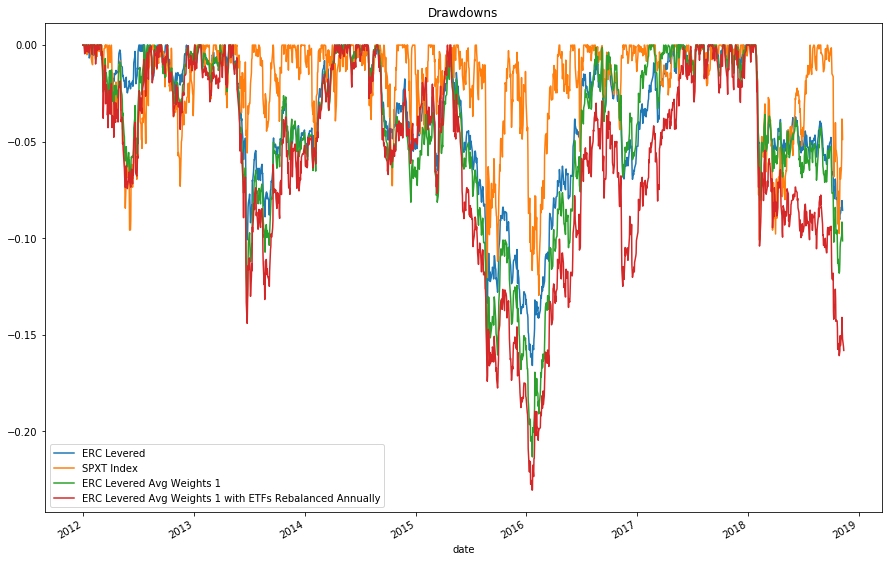

In [53]:
fig, ax = plt.subplots(nrows=1,ncols=1)

(ffn.to_drawdown_series(res_erc_levered.prices.loc[start_date:])).plot(ax=ax)
(ffn.to_drawdown_series(sp500_prices.loc[start_date:])).plot(ax=ax)
(ffn.to_drawdown_series(res_erc_levered_avg_weights_1.prices.loc[start_date:])).plot(ax=ax)
(ffn.to_drawdown_series(res_erc_levered_avw1_w_etf_reb_ann.prices.loc[start_date:])).plot(ax=ax)

ax.legend()
ax.set_title('Drawdowns')
ax.plot()
plt.show()

The drawdowns starting in 2011 ,which is when the data for the investable portfolio starts, seems to be worse than the portfolio that rebalances daily as expected.

# Transaction Costs

Since we don't have historical bid and ask prices and I do not think historical transaction costs are representative of future transaction costs, we will use current transaction costs to estimate annual transaction costs for the portfolion that rebalances annually.

I will estimate transactions costs like so:

$$mid = \frac{ask + bid}{2}$$
$$Dollar Cost = ask - mid = mid - bid = \frac{ask - bid}{2}$$
$$Cost = \frac{Dollar\ Cost}{mid}$$
Cost represents the percent cost of trading the corresponding ETF.
$$Portfolio\ Cost = \sum_{i \in assets} \%\ of\ Portfolio\ Traded\ Annually * Weight_{i} * Cost_{i}$$
I will assume the fraction of the portfolio traded annually to be 50%. Portfolio Cost is the percentage cost of annually rebalancing the portfolio.


These prices and bid-ask spreads are as of 11/12/2018 and 11/13/2018 for UST.

In [54]:
mids = {
    'UPRO US Equity':46.61,
    'UST US Equity':52.03,
    'TIP US Equity':108.91,
    'LTPZ US Equity':61.44,
    'DJP US Equity':23.19,
    'EDC US Equity':62.02
}
mids = pd.Series(mids)
dollarcost = {
    'UPRO US Equity':0.01/2,
    'UST US Equity':0.03/2,
    'TIP US Equity':0.01/2,
    'LTPZ US Equity':0.13/2,
    'DJP US Equity':0.01/2,
    'EDC US Equity':0.08/2
}
dollarcost = pd.Series(dollarcost)
cost = dollarcost/mids
print(cost)
print("Portfolio Cost: %0.2f%%" % np.sum(0.5*avg_weights_1_levered_with_etfs*cost*100))

DJP US Equity     0.000216
EDC US Equity     0.000645
LTPZ US Equity    0.001058
TIP US Equity     0.000046
UPRO US Equity    0.000107
UST US Equity     0.000288
dtype: float64
Portfolio Cost: 0.03%


The annual cost of rebalancing to the portfolio is roughly 0.03% of the portfolio annually. I didn't include it in the live portfolio but it doesn't seem to be very consequential if you trade once a year.

# Management Fees and Tracking Error


The management cost in each of the ETFs is included in the live trading example. The implicit cost that comes with tracking error is also embedded in the live trading example as well.

For comparison you can see the management cost of the ETFs included below.

The fees are as of 11/12/2018.

In [55]:
mgmt_fee = {
    'UPRO US Equity':0.0095,
    'UST US Equity':0.0095,
    'TIP US Equity':0.002,
    'LTPZ US Equity':0.002,
    'DJP US Equity':0.007,
    'EDC US Equity':0.0095
}
mgmt_fee = pd.Series(mgmt_fee)
print(mgmt_fee)

print("Portfolio Management Fee: %0.2f%%" % np.sum(avg_weights_1_levered_with_etfs*mgmt_fee*100))

DJP US Equity     0.0070
EDC US Equity     0.0095
LTPZ US Equity    0.0020
TIP US Equity     0.0020
UPRO US Equity    0.0095
UST US Equity     0.0095
dtype: float64
Portfolio Management Fee: 0.67%


# Recap

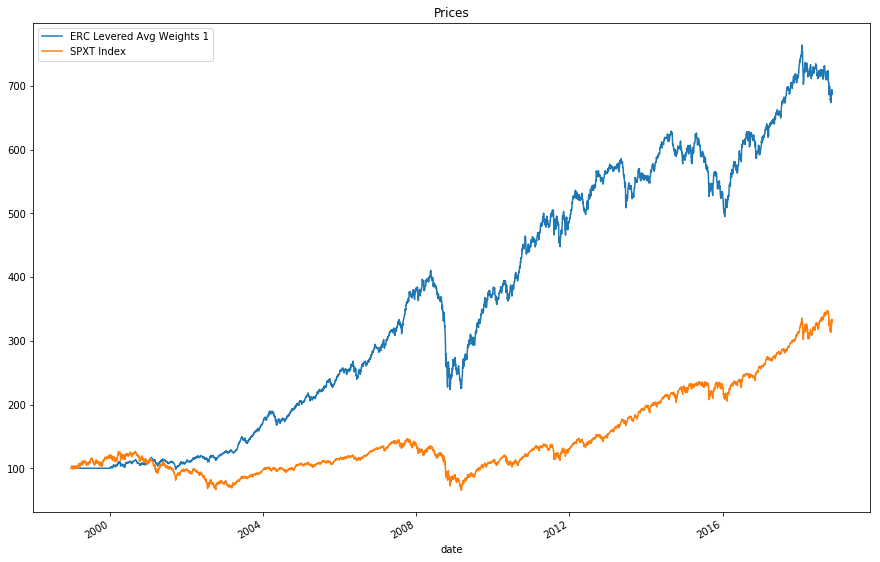

In [56]:
fig, ax = plt.subplots(nrows=1,ncols=1)

res_erc_levered_avg_weights_1.prices.plot(ax=ax)
sp500_prices.plot(ax=ax)

ax.legend()
ax.set_title('Prices')
ax.plot()
plt.show()

Over the long run a diversified, levered portfolio should outperform any one asset class.

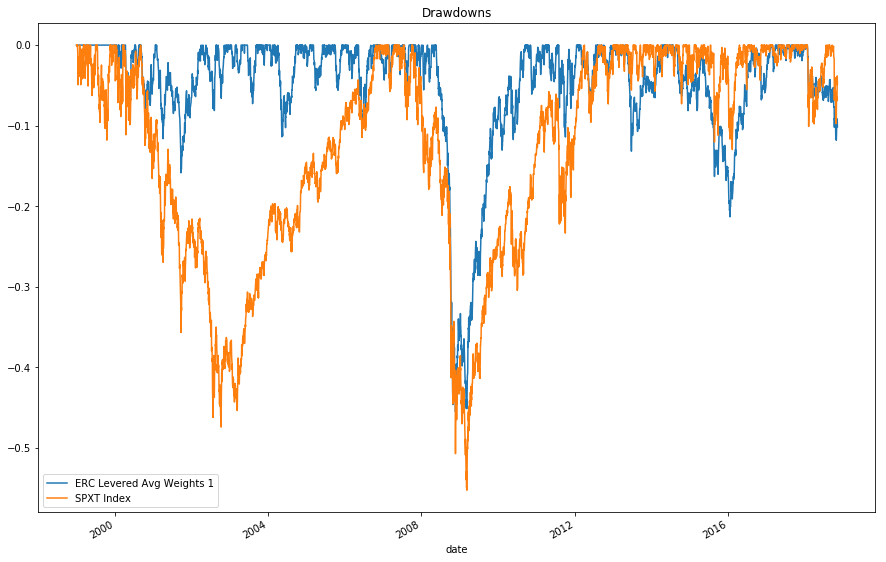

In [57]:
fig, ax = plt.subplots(nrows=1,ncols=1)

(ffn.to_drawdown_series(res_erc_levered_avg_weights_1.prices)).plot(ax=ax)
(ffn.to_drawdown_series(sp500_prices)).plot(ax=ax)

ax.legend()
ax.set_title('Drawdowns')
ax.plot()
plt.show()

Diversification does not spare you from drawdowns. In 08, a diversified portfolio was down 50%.

#### Unlevered Index exposures

In [58]:
for c in avg_weights_1.index:
    print("%s:\t%0.2f%%" % (tickers[c], avg_weights_1[c]*100))

Commodities:	10.00%
US TIPS:	30.00%
US Treasury:	30.00%
Emerging Market Equities:	15.00%
US Equities:	15.00%


#### Levered Index exposures

In [59]:
for c in avg_weights_1.index:
    print("%s:\t%0.2f%%" % (tickers[c], avg_weights_1[c]*100*2))

Commodities:	20.00%
US TIPS:	60.00%
US Treasury:	60.00%
Emerging Market Equities:	30.00%
US Equities:	30.00%


#### Investable ETF exposures

In [60]:
for c in avg_weights_1_levered_with_etfs.index:
    print("%s:\t%0.2f%%" % (c, avg_weights_1_levered_with_etfs[c]*100))

DJP US Equity:	20.00%
EDC US Equity:	10.00%
LTPZ US Equity:	30.00%
UPRO US Equity:	10.00%
UST US Equity:	30.00%


UPRO - US Equities ETF 3x Levered

UST - US Treasuries ETF 2x Levered

TIP - US TIPS ETF

LTPZ - US Long Duration TIPS ETF

DJP - iPath Bloomberg Commodity Index Total Return ETN

EDC - Emerging Market Equities ETF 3x Levered

In [61]:
print("Cash: %0.2f%%" % (100*(1-avg_weights_1_levered_with_etfs.sum())))

Cash: 0.00%


If you have any cash left over it should be invested in a short term treasury etf. Preferably with a duration under 3 years.

In [63]:
market_value = 100000
print("Shares to Buy")
avg_weights_1_levered_with_etfs*market_value/np.array(
    [
        22.90,
        64.48,
        61.44,
        45.75,
        52.03
    ]
)

Shares to Buy


DJP US Equity     873.362445
EDC US Equity     155.086849
LTPZ US Equity    488.281250
UPRO US Equity    218.579235
UST US Equity     576.590429
dtype: float64

#### Live Results

In [64]:
statsdf_actual.loc[
    [
        'cagr',
        'max_drawdown',
        'monthly_sharpe',
        'monthly_mean',
        'monthly_vol',
        'win_year_perc'
    ],
    ['ERC Levered Avg Weights 1 with ETFs Rebalanced Annually']
]

,ERC Levered Avg Weights 1 with ETFs Rebalanced Annually
cagr,0.038994
max_drawdown,-0.230465
monthly_sharpe,0.420489
monthly_mean,0.0432667
monthly_vol,0.102896
win_year_perc,0.571429


The live results since 2011 have an annual return of 4% and an annual volatility of 10.3%.

#### Historical Results

In [65]:
statsdf_levered.loc[
    [
        'cagr',
        'max_drawdown',
        'monthly_sharpe',
        'monthly_mean',
        'monthly_vol',
        'win_year_perc'
    ],
    ['ERC Levered Avg Weights 1']
]

,ERC Levered Avg Weights 1
cagr,0.101862
max_drawdown,-0.455261
monthly_sharpe,0.675054
monthly_mean,0.105507
monthly_vol,0.128435
win_year_perc,0.75


The historical results using index returns have an annual return of 10% and an annual volatility of 12.8%.



You can see the returns from the live results and historical results are fairly different(4% to 10%) while the volatility is roughly the same (10.3% to 12.8%). In practice volatility is much easier to predict than returns. If you assume that you get paid to risk equally among asset classes, then it is much easier to estimate your long term expected return using your volatility estimate and an estimate of what return you get paid per unit of volatility(Sharpe).

It is standard to assume a diversified portfolio has a Sharpe ratio(the excess returns above the risk free rate you expect to get per unit of volatility) of 0.5 and a single asset class has a Sharpe ratio of 0.25. This is what you see historically if you look back starting in the early 70's or earlier.

https://www.investopedia.com/terms/s/sharperatio.asp

In that case, a long run volatility of 12.5% should yield 6.25% excess returns. If you proxy the risk free rate by the 3 month Libor which is at 2.5%, then you expect an annual return of 8.75%.

You can read more about forward looking return estimates for asset classes at one of the links below. The gist of it is the best estimate for returns of any one asset class isn't high which supports the use of diversification and leverage.


* https://www.aqr.com/Insights/Research/Alternative-Thinking/2018-Capital-Market-Assumptions-for-Major-Asset-Classes
* https://am.jpmorgan.com/us/institutional/ltcma-interactive-assumptions-matrices
* https://www.blackrock.com/institutions/en-us/insights/portfolio-design/capital-market-assumptions



# Appendix

LTPZ is an ETF that is 15+ year US TIPS. Longer duration TIPS should act like levered TIPS in the long run because most changes in the Real Yield Curve are paralell shifts.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


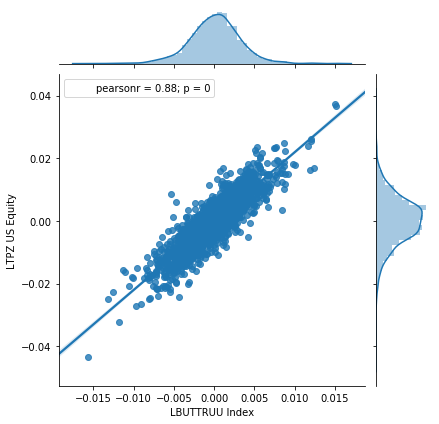

In [66]:
sns.jointplot(rdf.reindex(rdf_etf.index).loc[:,'LBUTTRUU Index'].dropna(), rdf_etf.loc[:,'LTPZ US Equity'].dropna(), kind="reg")

In [67]:
X = sm.add_constant(rdf.reindex(rdf_etf.index).loc[:,'LBUTTRUU Index'].dropna())
y = rdf_etf.reindex(X.index).loc[:,'LTPZ US Equity'].dropna()
X = X.reindex(y.index)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         LTPZ US Equity   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     7670.
Date:                Tue, 13 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:00:38   Log-Likelihood:                 9104.6
No. Observations:                2172   AIC:                        -1.821e+04
Df Residuals:                    2170   BIC:                        -1.819e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.335e-05   7.86e-05     -0.552      0.581      -0.000       0.000
LBUTTRUU Index     2.1957      0.025     87.579      0.000       2.146       2.245
==============================================================================
Omnibus:                       68.967   Durbin-Watson:                   2.454
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.086
Skew:                           0.073   Prob(JB):                     9.56e-39
Kurtosis:                       4.383   Cond. No.                         319.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


[]

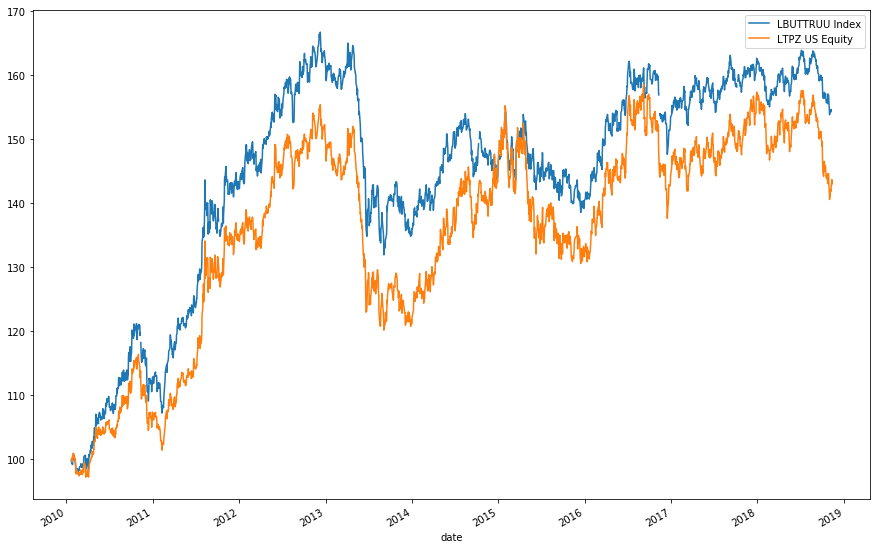

In [68]:
fig, ax = plt.subplots(nrows=1,ncols=1)

(np.cumprod(1 + rdf.loc[pdf_etf2.index,'LBUTTRUU Index']*2)*100).plot(ax=ax)
pdf_etf2.loc[:,'LTPZ US Equity'].plot(ax=ax)

ax.legend()
ax.plot()